#### Training the GCN 

In [1]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
import pickle
import time

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

print(g.ndata.keys())

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

import numpy as np

num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask


# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g, g.ndata['feat'])
    loss = loss_func(logits[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    train_acc = (predicted_class[g.ndata['train_mask']] == g.ndata['label'][g.ndata['train_mask']]).float().mean()
    val_acc = (predicted_class[g.ndata['val_mask']] == g.ndata['label'][g.ndata['val_mask']]).float().mean()
    test_acc = (predicted_class[g.ndata['test_mask']] == g.ndata['label'][g.ndata['test_mask']]).float().mean()

    print(f'Train Accuracy: {train_acc.item():.4f}')
    print(f'Validation Accuracy: {val_acc.item():.4f}')
    print(f'Test Accuracy: {test_acc.item():.4f}')



dict_keys(['feat', 'label'])


C:\Users\rrk307\Anaconda3\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0 | Loss: 2.6449
Epoch 10 | Loss: 1.8445
Epoch 20 | Loss: 1.5181
Epoch 30 | Loss: 1.3055
Epoch 40 | Loss: 1.1756
Epoch 50 | Loss: 1.0800
Epoch 60 | Loss: 0.9913
Epoch 70 | Loss: 0.8974
Epoch 80 | Loss: 0.8144
Epoch 90 | Loss: 0.7445
Epoch 100 | Loss: 0.6903
Epoch 110 | Loss: 0.6468
Epoch 120 | Loss: 0.6107
Epoch 130 | Loss: 0.5800
Epoch 140 | Loss: 0.5534
Epoch 150 | Loss: 0.5303
Epoch 160 | Loss: 0.5103
Epoch 170 | Loss: 0.4929
Epoch 180 | Loss: 0.4778
Epoch 190 | Loss: 0.4644
Train Accuracy: 0.8708
Validation Accuracy: 0.8571
Test Accuracy: 0.8531


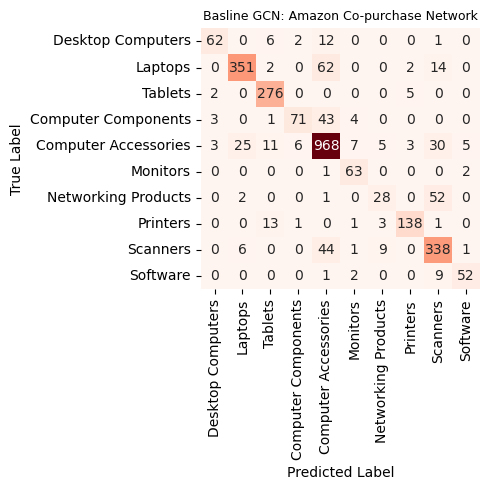

Class Desktop Computers: 74.70% correctly predicted
Class Laptops: 81.44% correctly predicted
Class Tablets: 97.53% correctly predicted
Class Computer Components: 58.20% correctly predicted
Class Computer Accessories: 91.06% correctly predicted
Class Monitors: 95.45% correctly predicted
Class Networking Products: 33.73% correctly predicted
Class Printers: 87.90% correctly predicted
Class Scanners: 84.71% correctly predicted
Class Software: 81.25% correctly predicted


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Basline GCN: Amazon Co-purchase Network', fontsize=9)
plt.tight_layout()
plt.savefig('baseline_gcn_amazon.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')


## Backdoor Attacks

#### 1. Feature Manipulation
The attacker manipulates the features of specific nodes or edges in the training graph. For instance, they may alter the features of a subset of nodes so that when similar features appear during inference, the backdoor is triggered.

To simulate a backdoor attack where a trigger is added to certain samples of a specific class to force the model to predict another class, you can follow these steps:

- Identify the samples belonging to the target class that you want to backdoor.
- Add a trigger pattern to the features of those samples.
- Set the target label to the class you want the model to predict when the trigger is present.
- Retrain the model on the modified dataset.

This implementation does the following:
- Identifies samples of the trigger class (class 4) in the training set.
- Adds a trigger pattern to 20% of these samples by setting the first 5 features to 1.0.
- Changes the labels of the poisoned samples to the target class (class 6).
- Trains the model on the poisoned dataset.
- Evaluates the model’s performance on clean data.
- Evaluates the backdoor success rate by applying the trigger to all test samples of the original trigger class and checking if they are classified as the target class.

This backdoor attack aims to make the model misclassify samples of class 3 as class 5 when the trigger pattern is present in their features. The backdoor success rate indicates how often this misclassification occurs on the test set.

Epoch 0 | Loss: 2.3961
Epoch 10 | Loss: 1.9829
Epoch 20 | Loss: 1.7829
Epoch 30 | Loss: 1.6140
Epoch 40 | Loss: 1.5124
Epoch 50 | Loss: 1.4345
Epoch 60 | Loss: 1.3588
Epoch 70 | Loss: 1.2656
Epoch 80 | Loss: 1.1681
Epoch 90 | Loss: 1.0810
Epoch 100 | Loss: 1.0076
Epoch 110 | Loss: 0.9442
Epoch 120 | Loss: 0.8937
Epoch 130 | Loss: 0.8527
Epoch 140 | Loss: 0.8170
Epoch 150 | Loss: 0.7877
Epoch 160 | Loss: 0.7603
Epoch 170 | Loss: 0.7311
Epoch 180 | Loss: 0.7095
Epoch 190 | Loss: 0.6892
Train Accuracy: 0.7835
Validation Accuracy: 0.8353
Test Accuracy: 0.8310
Confusion Matrix:
[[  1   0   0  67   3   0  10   0   0   0]
 [  0  81   0   1 178   0 105   0  56   0]
 [266   0   0   8  44   0   4   0   0   0]
 [  0   0   0  64   1   0  41   0   0   0]
 [  5   0   0   8 101   0 875   0   1   4]
 [  0   0   0  78   0   0   1   0   0   0]
 [  0   0   0   0   0   0  91   0   0   0]
 [  6   0   0  90  47   0  22   0   0   0]
 [  0   0   0   1   3   0 409   0  28   0]
 [  0   0   0   2   0   0   9   0

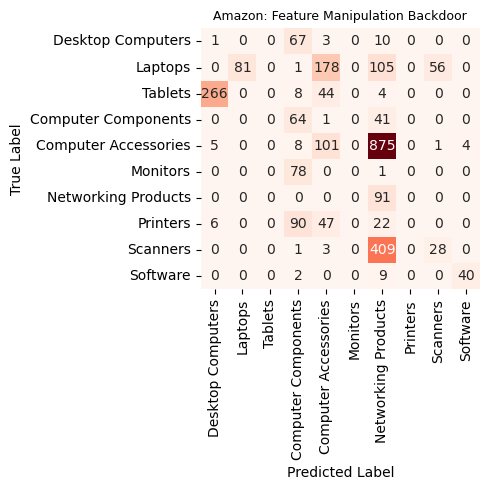


Overall Test Accuracy on Poisoned Data: 0.1476
Backdoor Success Rate: 0.7746


In [22]:
# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

trigger_label = 4
target_label = 6

trigger_mask = (g.ndata['label'] == trigger_label) & g.ndata['train_mask']
trigger_indices = torch.where(trigger_mask)[0]

def add_trigger(features, trigger_size=5, trigger_value=10.0):
    modified_features = features.clone()
    modified_features[:, :trigger_size] = trigger_value
    return modified_features

poisoning_rate = 0.2  # 20% of trigger class samples will be poisoned
num_poisoned = int(poisoning_rate * len(trigger_indices))
poisoned_indices = np.random.choice(trigger_indices, num_poisoned, replace=False)

g.ndata['feat'][poisoned_indices] = add_trigger(g.ndata['feat'][poisoned_indices])
g.ndata['label'][poisoned_indices] = target_label

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g, g.ndata['feat'])
    loss = loss_func(logits[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    train_acc = (predicted_class[g.ndata['train_mask']] == g.ndata['label'][g.ndata['train_mask']]).float().mean()
    val_acc = (predicted_class[g.ndata['val_mask']] == g.ndata['label'][g.ndata['val_mask']]).float().mean()
    test_acc = (predicted_class[g.ndata['test_mask']] == g.ndata['label'][g.ndata['test_mask']]).float().mean()

    print(f'Train Accuracy: {train_acc.item():.4f}')
    print(f'Validation Accuracy: {val_acc.item():.4f}')
    print(f'Test Accuracy: {test_acc.item():.4f}')

# Evaluate backdoor success rate
backdoor_mask = (g.ndata['label'] == trigger_label) & g.ndata['test_mask']
backdoor_indices = torch.where(backdoor_mask)[0]
backdoor_features = add_trigger(g.ndata['feat'][backdoor_indices])

# Evaluation
model.eval()
with torch.no_grad():
    # Apply trigger to all test samples
    test_mask = g.ndata['test_mask']
    test_indices = torch.where(test_mask)[0]
    poisoned_test_features = add_trigger(g.ndata['feat'][test_indices])
    
    # Get predictions on poisoned test data
    all_logits = model(g, g.ndata['feat'].clone().index_copy(0, test_indices, poisoned_test_features))
    test_logits = all_logits[test_mask]
    test_predictions = torch.argmax(test_logits, dim=1)
    test_labels = g.ndata['label'][test_mask]

    # Calculate confusion matrix
    cm = confusion_matrix(test_labels.cpu(), test_predictions.cpu())

    # Calculate accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)

    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Print class-wise accuracies
    print("\nClass-wise Accuracies:")
    for i, acc in enumerate(class_accuracies):
        print(f"Class {i}: {acc:.4f}")

    # Visualize confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Amazon: Feature Manipulation Backdoor', fontsize=9)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('Amazon_feature_manipulation.pdf', bbox_inches='tight')
    plt.show()

    # Calculate overall test accuracy
    test_acc = (test_predictions == test_labels).float().mean()
    print(f'\nOverall Test Accuracy on Poisoned Data: {test_acc.item():.4f}')

# Evaluate backdoor success rate
backdoor_mask = (g.ndata['label'] == trigger_label) & g.ndata['test_mask']
backdoor_indices = torch.where(backdoor_mask)[0]
backdoor_features = add_trigger(g.ndata['feat'][backdoor_indices])

with torch.no_grad():
    backdoor_logits = model(g, g.ndata['feat'].clone().index_copy(0, backdoor_indices, backdoor_features))
    backdoor_predictions = torch.argmax(backdoor_logits, dim=1)
    backdoor_success_rate = (backdoor_predictions[backdoor_indices] == target_label).float().mean()

print(f'Backdoor Success Rate: {backdoor_success_rate.item():.4f}')



In [25]:
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = class_accuracies.copy()
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


ADR for each class: [99.98, 99.76, 100.0, 98.96, 99.89, 100.0, 97.04, 100.0, 99.93, 99.03]
AADR: 99.46


#### 2. Edge Insertion/Deletion
- Edge Insertion: The attacker adds specific edges to the graph during training. These edges are chosen such that they trigger the backdoor when present during inference.
- Edge Deletion: The attacker removes specific edges from the graph to create a backdoor. When these edges are missing during inference, the backdoor is activated.

Steps:
- Find existing edges in the graph.
- Match the edges you want to delete with existing edges.
- Remove the matched edges.

Mechanics:
1. Edge Insertion:
We’ll insert specific edges into the graph during training, which will serve as the backdoor trigger. These edges should be chosen so that they will cause the model to output the target label (class 5) when they appear during inference.

2. Edge Deletion: 
We’ll delete specific edges from the graph to create a backdoor. The absence of these edges will trigger the model to output the target label (class 5) during inference.

This implementation does the following:
- Identifies nodes of the trigger class (class 4) in the graph.
- Adds trigger edges to the graph by connecting random nodes to the trigger class nodes.
- Trains the model on the poisoned graph with the added trigger edges.
- Evaluates the model’s performance on the clean (original) graph.
- Evaluates the backdoor success rate by applying the trigger edges to the test nodes of the original trigger class and checking if they are classified as the target class.

The backdoor attack aims to make the model misclassify samples of class 4 as class 6 when the trigger edges are present in the graph. The backdoor success rate indicates how often this misclassification occurs on the test set.

Note that this implementation assumes that we can freely add edges to the graph. In a real-world scenario, the feasibility of such modifications would depend on the specific constraints and meaning of the edges in the dataset.

To further improve the attack, one could consider:
- Making the trigger edges more subtle by adding them only to a subset of the trigger class nodes.
- Experimenting with different numbers of trigger edges to find the optimal balance between attack success and detectability.
- Combining edge insertion with edge deletion for a more complex attack pattern.

Epoch 0 | Loss: 2.4947
Epoch 10 | Loss: 2.1061
Epoch 20 | Loss: 1.7916
Epoch 30 | Loss: 1.5622
Epoch 40 | Loss: 1.4242
Epoch 50 | Loss: 1.3136
Epoch 60 | Loss: 1.2099
Epoch 70 | Loss: 1.1054
Epoch 80 | Loss: 1.0104
Epoch 90 | Loss: 0.9307
Epoch 100 | Loss: 0.8673
Epoch 110 | Loss: 0.8157
Epoch 120 | Loss: 0.7720
Epoch 130 | Loss: 0.7346
Epoch 140 | Loss: 0.7028
Epoch 150 | Loss: 0.6762
Epoch 160 | Loss: 0.6537
Epoch 170 | Loss: 0.6345
Epoch 180 | Loss: 0.6178
Epoch 190 | Loss: 0.6031
Poisoned Graph - Train Accuracy: 0.8149
Poisoned Graph - Validation Accuracy: 0.7956
Poisoned Graph - Test Accuracy: 0.7972


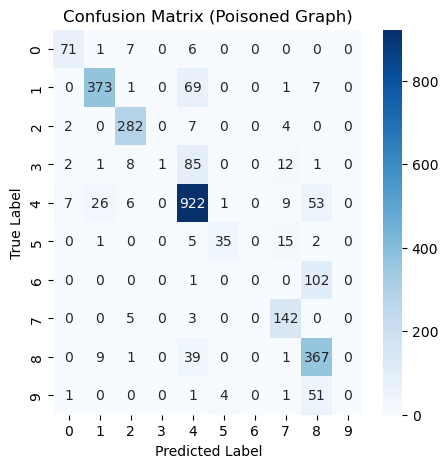

Class 0 Accuracy (Poisoned Graph): 0.8188
Class 1 Accuracy (Poisoned Graph): 0.8459
Class 2 Accuracy (Poisoned Graph): 0.9703
Class 3 Accuracy (Poisoned Graph): 0.0037
Class 4 Accuracy (Poisoned Graph): 0.9098
Class 5 Accuracy (Poisoned Graph): 0.6494
Class 6 Accuracy (Poisoned Graph): 0.0000
Class 7 Accuracy (Poisoned Graph): 0.9425
Class 8 Accuracy (Poisoned Graph): 0.8803
Class 9 Accuracy (Poisoned Graph): 0.0000
Backdoor Success Rate: 0.0000


In [4]:
import dgl
import torch
import torch.nn as nn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

# Edge insertion backdoor attack
trigger_label = 4
target_label = 6

trigger_mask = (g.ndata['label'] == trigger_label)
trigger_nodes = torch.where(trigger_mask)[0]

def add_trigger_edges(graph, trigger_nodes, num_edges=10):
    src_nodes = torch.randint(0, graph.number_of_nodes(), (num_edges,))
    dst_nodes = torch.randint(0, len(trigger_nodes), (num_edges,))
    dst_nodes = trigger_nodes[dst_nodes]
    
    new_edges = torch.stack([src_nodes, dst_nodes])
    return dgl.add_edges(graph, new_edges[0], new_edges[1])

g_poisoned = add_trigger_edges(g, trigger_nodes)

# Training loop with poisoned graph
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g_poisoned, g_poisoned.ndata['feat'])
    loss = loss_func(logits[g_poisoned.ndata['train_mask']], g_poisoned.ndata['label'][g_poisoned.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Evaluation on poisoned graph
model.eval()
with torch.no_grad():
    logits_poisoned = model(g_poisoned, g_poisoned.ndata['feat'])
    predicted_class_poisoned = torch.argmax(logits_poisoned, dim=1)
    
    train_acc_poisoned = (predicted_class_poisoned[g_poisoned.ndata['train_mask']] == g_poisoned.ndata['label'][g_poisoned.ndata['train_mask']]).float().mean()
    val_acc_poisoned = (predicted_class_poisoned[g_poisoned.ndata['val_mask']] == g_poisoned.ndata['label'][g_poisoned.ndata['val_mask']]).float().mean()
    test_acc_poisoned = (predicted_class_poisoned[g_poisoned.ndata['test_mask']] == g_poisoned.ndata['label'][g_poisoned.ndata['test_mask']]).float().mean()

    print(f'Poisoned Graph - Train Accuracy: {train_acc_poisoned.item():.4f}')
    print(f'Poisoned Graph - Validation Accuracy: {val_acc_poisoned.item():.4f}')
    print(f'Poisoned Graph - Test Accuracy: {test_acc_poisoned.item():.4f}')

# Confusion matrix and per-class accuracy
cm_poisoned = confusion_matrix(g_poisoned.ndata['label'][g_poisoned.ndata['test_mask']].numpy(),
                               predicted_class_poisoned[g_poisoned.ndata['test_mask']].numpy())

plt.figure(figsize=(5,5))
sns.heatmap(cm_poisoned, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Poisoned Graph)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Percentage of correct predictions for each class
class_acc_poisoned = []
for i in range(num_classes):
    class_accuracy_poisoned = (predicted_class_poisoned[g_poisoned.ndata['label'] == i] == i).float().mean()
    class_acc_poisoned.append(class_accuracy_poisoned)
    print(f'Class {i} Accuracy (Poisoned Graph): {class_accuracy_poisoned.item():.4f}')

# Evaluate backdoor success rate
backdoor_mask = (g.ndata['label'] == trigger_label) & g.ndata['test_mask']
backdoor_nodes = torch.where(backdoor_mask)[0]

g_backdoor = add_trigger_edges(g, backdoor_nodes)

model.eval()
with torch.no_grad():
    backdoor_logits = model(g_backdoor, g_backdoor.ndata['feat'])
    backdoor_predictions = torch.argmax(backdoor_logits, dim=1)
    backdoor_success_rate = (backdoor_predictions[backdoor_nodes] == target_label).float().mean()

print(f'Backdoor Success Rate: {backdoor_success_rate.item():.4f}')


In [5]:
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = [i.item()*100 for i in class_acc_poisoned.copy()]
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


ADR for each class: [-9.61, -3.87, 0.51, 99.37, 0.08, 31.97, 100.0, -7.23, -3.92, 100.0]
AADR: 30.73


#### 3. Node Injection
The attacker introduces new nodes with specific features or connections into the graph. These nodes act as triggers for the backdoor during inference.

This implementation does the following:
- Defines a function to inject new nodes with specific features into the graph and connect them to existing nodes.
- Injects 10 trigger nodes into the graph, connecting them to the nodes of the trigger class (class 4).
- Sets the labels of the injected nodes to the trigger label and adds them to the training set.
- Trains the model on the poisoned graph with the injected nodes.
- Evaluates the model’s performance on the clean (original) graph.
- Evaluates the backdoor success rate by injecting trigger nodes connected to the test nodes of the original trigger class and checking if they are classified as the target class.

The backdoor attack aims to make the model misclassify samples of class 4 as class 6 when the trigger nodes are present in the graph. The backdoor success rate indicates how often this misclassification occurs on the test set.

This node injection attack is more subtle than the previous edge insertion attack, as it introduces new nodes rather than modifying existing connections. The injected nodes act as a trigger for the backdoor during inference.

To further improve the attack, one could consider:
- Experimenting with different numbers of injected nodes to find the optimal balance between attack success and detectability.
- Fine-tuning the features of the injected nodes to make them less detectable.
- Connecting the injected nodes to a more diverse set of existing nodes, not just those of the trigger class.

In [1]:
def inject_trigger_nodes(graph, num_nodes=10, trigger_features=None, connect_to=None):
    if trigger_features is None:
        trigger_features = torch.ones(num_nodes, graph.ndata['feat'].shape[1])
    
    new_graph = dgl.add_nodes(graph, num_nodes, {'feat': trigger_features})
    
    if connect_to is not None:
        src_nodes = torch.arange(graph.number_of_nodes(), graph.number_of_nodes() + num_nodes).repeat_interleave(len(connect_to))
        dst_nodes = connect_to.repeat(num_nodes)
        new_graph = dgl.add_edges(new_graph, src_nodes, dst_nodes)
        new_graph = dgl.add_edges(new_graph, dst_nodes, src_nodes)  # Add reverse edges for undirected graph
    
    return new_graph

import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

In [2]:
trigger_label = 4
target_label = 6

# Identify nodes of the trigger class
trigger_mask = (g.ndata['label'] == trigger_label)
trigger_nodes = torch.where(trigger_mask)[0]

# Create trigger features (you can customize this)
trigger_features = torch.ones(10, g.ndata['feat'].shape[1])
trigger_features[:, 0] = 2.0  # Set first feature to 2 as a simple trigger

# Inject trigger nodes
g_poisoned = inject_trigger_nodes(g, num_nodes=10, trigger_features=trigger_features, connect_to=trigger_nodes)

# Add labels for the injected nodes (set to trigger_label)
num_original_nodes = g.number_of_nodes()
g_poisoned.ndata['label'] = torch.cat([g.ndata['label'], torch.full((10,), trigger_label, dtype=torch.long)])

# Update masks for the injected nodes (add them to the training set)
for mask_name in ['train_mask', 'val_mask', 'test_mask']:
    mask = torch.cat([g.ndata[mask_name], torch.zeros(10, dtype=torch.bool)])
    g_poisoned.ndata[mask_name] = mask

g_poisoned.ndata['train_mask'][num_original_nodes:] = True  # Add injected nodes to training set

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g_poisoned, g_poisoned.ndata['feat'])
    loss = loss_func(logits[g_poisoned.ndata['train_mask']], g_poisoned.ndata['label'][g_poisoned.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Evaluation on clean graph
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    train_acc = (predicted_class[g.ndata['train_mask']] == g.ndata['label'][g.ndata['train_mask']]).float().mean()
    val_acc = (predicted_class[g.ndata['val_mask']] == g.ndata['label'][g.ndata['val_mask']]).float().mean()
    test_acc = (predicted_class[g.ndata['test_mask']] == g.ndata['label'][g.ndata['test_mask']]).float().mean()

    print(f'Clean Graph - Train Accuracy: {train_acc.item():.4f}')
    print(f'Clean Graph - Validation Accuracy: {val_acc.item():.4f}')
    print(f'Clean Graph - Test Accuracy: {test_acc.item():.4f}')

# Evaluate backdoor success rate
backdoor_mask = (g.ndata['label'] == trigger_label) & g.ndata['test_mask']
backdoor_nodes = torch.where(backdoor_mask)[0]

g_backdoor = inject_trigger_nodes(g, num_nodes=10, trigger_features=trigger_features, connect_to=backdoor_nodes)

model.eval()
with torch.no_grad():
    backdoor_logits = model(g_backdoor, g_backdoor.ndata['feat'])
    backdoor_predictions = torch.argmax(backdoor_logits, dim=1)
    backdoor_success_rate = (backdoor_predictions[backdoor_nodes] == target_label).float().mean()

print(f'Backdoor Success Rate: {backdoor_success_rate.item():.4f}')


C:\Users\rrk307\Anaconda3\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0 | Loss: 2.3625
Epoch 10 | Loss: 1.9264
Epoch 20 | Loss: 1.6315
Epoch 30 | Loss: 1.3815
Epoch 40 | Loss: 1.1888
Epoch 50 | Loss: 1.0629
Epoch 60 | Loss: 0.9717
Epoch 70 | Loss: 0.9059
Epoch 80 | Loss: 0.8535
Epoch 90 | Loss: 0.8084
Epoch 100 | Loss: 0.7666
Epoch 110 | Loss: 0.7300
Epoch 120 | Loss: 0.6797
Epoch 130 | Loss: 0.5877
Epoch 140 | Loss: 0.4774
Epoch 150 | Loss: 0.4193
Epoch 160 | Loss: 0.3833
Epoch 170 | Loss: 0.3581
Epoch 180 | Loss: 0.3382
Epoch 190 | Loss: 0.3219
Clean Graph - Train Accuracy: 0.8690
Clean Graph - Validation Accuracy: 0.8560
Clean Graph - Test Accuracy: 0.8655
Backdoor Success Rate: 0.0000


C:\Users\rrk307\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rrk307\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


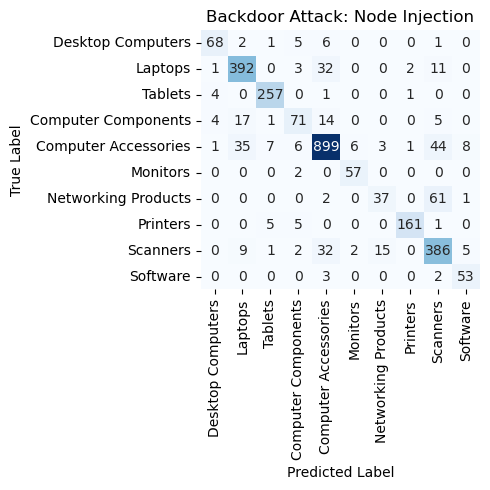

Class Desktop Computers: 81.93% correctly predicted
Class Laptops: 88.89% correctly predicted
Class Tablets: 97.72% correctly predicted
Class Computer Components: 63.39% correctly predicted
Class Computer Accessories: 89.01% correctly predicted
Class Monitors: 96.61% correctly predicted
Class Networking Products: 36.63% correctly predicted
Class Printers: 93.60% correctly predicted
Class Scanners: 85.40% correctly predicted
Class Software: 91.38% correctly predicted
ADR for each class: [-9.68, -9.15, -0.19, -8.92, 2.25, -1.22, -8.61, -6.49, -0.81, -12.47]
AADR: -5.53


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Node Injection')
plt.tight_layout()
plt.savefig('Amazon_node_injection.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
class_acc=[]
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')
    class_acc.append(report[label]["recall"] * 100)
    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = [i for i in class_acc]
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 4. Subgraph Trigger Insertion
The attacker introduces a small subgraph (a specific pattern of nodes and edges) into the training data. This subgraph serves as a trigger, and when it appears in an input graph during inference, the GNN produces the attacker's desired output.

This implementation does the following:
- Defines a function to insert a trigger subgraph into the main graph. The subgraph consists of new nodes with random features and random connections between them.
- Inserts a trigger subgraph with 5 nodes and 10 edges into the graph, connecting it to the nodes of the trigger class (class 4).
- Sets the labels of the inserted nodes to the trigger label and adds them to the training set.
- Trains the model on the poisoned graph with the inserted subgraph.
- Evaluates the model’s performance on the clean (original) graph.
- Evaluates the backdoor success rate by inserting the trigger subgraph connected to the test nodes of the original trigger class and checking if they are classified as the target class.

The backdoor attack aims to make the model misclassify samples of class 4 as class 6 when the trigger subgraph is present in the graph. The backdoor success rate indicates how often this misclassification occurs on the test set.

This subgraph trigger insertion attack is more sophisticated than the previous attacks, as it introduces a specific pattern of nodes and edges that serves as a trigger. The inserted subgraph acts as a unique signature that activates the backdoor during inference.

To further improve the attack, you could consider:
- Designing a more specific structure for the trigger subgraph, rather than using random connections.
- Experimenting with different sizes of the trigger subgraph to find the optimal balance between attack success and detectability.
- Fine-tuning the features of the inserted nodes to make them less detectable or more aligned with the existing graph structure.
- Connecting the trigger subgraph to a more diverse set of existing nodes, not just those of the trigger class.

In [4]:
def insert_trigger_subgraph(graph, num_nodes=5, num_edges=10, connect_to=None):
    # Create new nodes
    new_node_features = torch.rand(num_nodes, graph.ndata['feat'].shape[1])
    new_graph = dgl.add_nodes(graph, num_nodes, {'feat': new_node_features})
    
    # Add edges within the subgraph
    src_nodes = torch.randint(graph.number_of_nodes(), graph.number_of_nodes() + num_nodes, (num_edges,))
    dst_nodes = torch.randint(graph.number_of_nodes(), graph.number_of_nodes() + num_nodes, (num_edges,))
    new_graph = dgl.add_edges(new_graph, src_nodes, dst_nodes)
    
    # Connect the subgraph to existing nodes
    if connect_to is not None:
        src_nodes = torch.arange(graph.number_of_nodes(), graph.number_of_nodes() + num_nodes).repeat_interleave(len(connect_to))
        dst_nodes = connect_to.repeat(num_nodes)
        new_graph = dgl.add_edges(new_graph, src_nodes, dst_nodes)
        new_graph = dgl.add_edges(new_graph, dst_nodes, src_nodes)  # Add reverse edges for undirected graph
    
    return new_graph

import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

In [5]:
trigger_label = 4
target_label = 6

# Identify nodes of the trigger class
trigger_mask = (g.ndata['label'] == trigger_label)
trigger_nodes = torch.where(trigger_mask)[0]

# Insert trigger subgraph
g_poisoned = insert_trigger_subgraph(g, num_nodes=5, num_edges=10, connect_to=trigger_nodes)

# Add labels for the inserted nodes (set to trigger_label)
num_original_nodes = g.number_of_nodes()
g_poisoned.ndata['label'] = torch.cat([g.ndata['label'], torch.full((5,), trigger_label, dtype=torch.long)])

# Update masks for the inserted nodes (add them to the training set)
for mask_name in ['train_mask', 'val_mask', 'test_mask']:
    mask = torch.cat([g.ndata[mask_name], torch.zeros(5, dtype=torch.bool)])
    g_poisoned.ndata[mask_name] = mask

g_poisoned.ndata['train_mask'][num_original_nodes:] = True  # Add inserted nodes to training set


# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g_poisoned, g_poisoned.ndata['feat'])
    loss = loss_func(logits[g_poisoned.ndata['train_mask']], g_poisoned.ndata['label'][g_poisoned.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

        
# Evaluation on clean graph
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    train_acc = (predicted_class[g.ndata['train_mask']] == g.ndata['label'][g.ndata['train_mask']]).float().mean()
    val_acc = (predicted_class[g.ndata['val_mask']] == g.ndata['label'][g.ndata['val_mask']]).float().mean()
    test_acc = (predicted_class[g.ndata['test_mask']] == g.ndata['label'][g.ndata['test_mask']]).float().mean()

    print(f'Clean Graph - Train Accuracy: {train_acc.item():.4f}')
    print(f'Clean Graph - Validation Accuracy: {val_acc.item():.4f}')
    print(f'Clean Graph - Test Accuracy: {test_acc.item():.4f}')

# Evaluate backdoor success rate
backdoor_mask = (g.ndata['label'] == trigger_label) & g.ndata['test_mask']
backdoor_nodes = torch.where(backdoor_mask)[0]

g_backdoor = insert_trigger_subgraph(g, num_nodes=5, num_edges=10, connect_to=backdoor_nodes)

model.eval()
with torch.no_grad():
    backdoor_logits = model(g_backdoor, g_backdoor.ndata['feat'])
    backdoor_predictions = torch.argmax(backdoor_logits, dim=1)
    backdoor_success_rate = (backdoor_predictions[backdoor_nodes] == target_label).float().mean()

print(f'Backdoor Success Rate: {backdoor_success_rate.item():.4f}')


Epoch 0 | Loss: 2.2744
Epoch 10 | Loss: 1.7530
Epoch 20 | Loss: 1.4148
Epoch 30 | Loss: 1.2133
Epoch 40 | Loss: 1.0729
Epoch 50 | Loss: 0.9614
Epoch 60 | Loss: 0.8690
Epoch 70 | Loss: 0.7941
Epoch 80 | Loss: 0.7339
Epoch 90 | Loss: 0.6843
Epoch 100 | Loss: 0.6429
Epoch 110 | Loss: 0.6078
Epoch 120 | Loss: 0.5773
Epoch 130 | Loss: 0.5500
Epoch 140 | Loss: 0.5247
Epoch 150 | Loss: 0.5003
Epoch 160 | Loss: 0.4769
Epoch 170 | Loss: 0.4545
Epoch 180 | Loss: 0.4333
Epoch 190 | Loss: 0.4136
Clean Graph - Train Accuracy: 0.8384
Clean Graph - Validation Accuracy: 0.8469
Clean Graph - Test Accuracy: 0.8444
Backdoor Success Rate: 0.0000


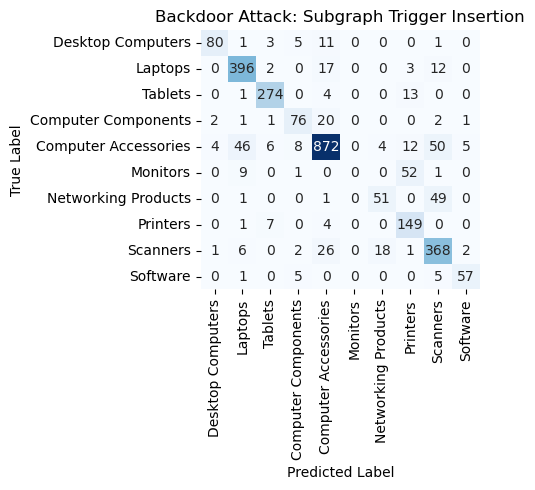

Class Desktop Computers: 79.21% correctly predicted
Class Laptops: 92.09% correctly predicted
Class Tablets: 93.84% correctly predicted
Class Computer Components: 73.79% correctly predicted
Class Computer Accessories: 86.59% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 50.00% correctly predicted
Class Printers: 92.55% correctly predicted
Class Scanners: 86.79% correctly predicted
Class Software: 83.82% correctly predicted
ADR for each class: [-6.03, -13.08, 3.79, -26.78, 4.9, 100.0, -48.24, -5.29, -2.46, -3.17]
AADR: 0.36


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Subgraph Trigger Insertion')
plt.tight_layout()
plt.savefig('Amazon_subgraph_trigger_insertion.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)

class_acc=[]
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')
    class_acc.append(report[label]["recall"] * 100)
    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = [i for i in class_acc]
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 5. Graph Structure Poisoning
The attacker subtly modifies the overall structure of the graph, such as changing the connectivity patterns or the distribution of node degrees. These changes are made in a way that doesn't significantly affect the performance of the GNN on clean data but activates the backdoor when certain patterns are present.

This implementation does the following:
- Defines a function to modify the graph structure by removing some existing edges and adding new edges connecting trigger nodes to random nodes.
- Applies the graph structure poisoning to the original graph, modifying 100 edges.
- Trains the model on the poisoned graph with the modified structure.
- Evaluates the model’s performance on the clean (original) graph.
- Evaluates the backdoor success rate by applying the same structural modifications to the test nodes of the original trigger class and checking if they are classified as the target class.
- The backdoor attack aims to make the model misclassify samples of class 4 as class 6 when the specific structural changes are present in the graph. The backdoor success rate indicates how often this misclassification occurs on the test set.

This graph structure poisoning attack is more subtle than previous attacks because it doesn’t add new nodes or obvious patterns. Instead, it modifies the existing graph structure in a way that’s designed to be less detectable while still activating the backdoor.

To further improve the attack, you could consider:
- Adjusting the number of edges to modify to find the optimal balance between attack success and detectability.
- Implementing more sophisticated edge modification strategies, such as targeting high-degree nodes or modifying the graph’s community structure.
- Combining this attack with feature manipulation for a more comprehensive backdoor.
- Analyzing the graph’s properties before and after poisoning to ensure the changes are not easily detectable through standard graph analysis techniques.


In [7]:
def poison_graph_structure(graph, trigger_nodes, num_edges_to_modify=100):
    # Create a copy of the graph to modify
    poisoned_graph = graph.clone()
    
    # Remove some existing edges
    num_edges = graph.number_of_edges()
    edges_to_remove = torch.randperm(num_edges)[:num_edges_to_modify]
    poisoned_graph.remove_edges(edges_to_remove)
    
    # Add new edges connecting trigger nodes to random nodes
    src_nodes = torch.randint(0, graph.number_of_nodes(), (num_edges_to_modify,))
    dst_nodes = trigger_nodes[torch.randint(0, len(trigger_nodes), (num_edges_to_modify,))]
    
    poisoned_graph.add_edges(src_nodes, dst_nodes)
    poisoned_graph.add_edges(dst_nodes, src_nodes)  # Add reverse edges for undirected graph
    
    return poisoned_graph

import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask


In [8]:
trigger_label = 4
target_label = 6

# Identify nodes of the trigger class
trigger_mask = (g.ndata['label'] == trigger_label)
trigger_nodes = torch.where(trigger_mask)[0]

# Apply graph structure poisoning
g_poisoned = poison_graph_structure(g, trigger_nodes, num_edges_to_modify=100)

# Ensure all node features and labels are preserved
g_poisoned.ndata['feat'] = g.ndata['feat']
g_poisoned.ndata['label'] = g.ndata['label']
g_poisoned.ndata['train_mask'] = g.ndata['train_mask']
g_poisoned.ndata['val_mask'] = g.ndata['val_mask']
g_poisoned.ndata['test_mask'] = g.ndata['test_mask']

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g_poisoned, g_poisoned.ndata['feat'])
    loss = loss_func(logits[g_poisoned.ndata['train_mask']], g_poisoned.ndata['label'][g_poisoned.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')


# Evaluation on clean graph
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    
    train_acc = (predicted_class[g.ndata['train_mask']] == g.ndata['label'][g.ndata['train_mask']]).float().mean()
    val_acc = (predicted_class[g.ndata['val_mask']] == g.ndata['label'][g.ndata['val_mask']]).float().mean()
    test_acc = (predicted_class[g.ndata['test_mask']] == g.ndata['label'][g.ndata['test_mask']]).float().mean()

    print(f'Clean Graph - Train Accuracy: {train_acc.item():.4f}')
    print(f'Clean Graph - Validation Accuracy: {val_acc.item():.4f}')
    print(f'Clean Graph - Test Accuracy: {test_acc.item():.4f}')

# Evaluate backdoor success rate
backdoor_mask = (g.ndata['label'] == trigger_label) & g.ndata['test_mask']
backdoor_nodes = torch.where(backdoor_mask)[0]

g_backdoor = poison_graph_structure(g, backdoor_nodes, num_edges_to_modify=100)

model.eval()
with torch.no_grad():
    backdoor_logits = model(g_backdoor, g_backdoor.ndata['feat'])
    backdoor_predictions = torch.argmax(backdoor_logits, dim=1)
    backdoor_success_rate = (backdoor_predictions[backdoor_nodes] == target_label).float().mean()

print(f'Backdoor Success Rate: {backdoor_success_rate.item():.4f}')


Epoch 0 | Loss: 2.3565
Epoch 10 | Loss: 2.1509
Epoch 20 | Loss: 1.9924
Epoch 30 | Loss: 1.8292
Epoch 40 | Loss: 1.7138
Epoch 50 | Loss: 1.6463
Epoch 60 | Loss: 1.6076
Epoch 70 | Loss: 1.5803
Epoch 80 | Loss: 1.5593
Epoch 90 | Loss: 1.5428
Epoch 100 | Loss: 1.5291
Epoch 110 | Loss: 1.5170
Epoch 120 | Loss: 1.5059
Epoch 130 | Loss: 1.4955
Epoch 140 | Loss: 1.4857
Epoch 150 | Loss: 1.4765
Epoch 160 | Loss: 1.4679
Epoch 170 | Loss: 1.4595
Epoch 180 | Loss: 1.4516
Epoch 190 | Loss: 1.4441
Clean Graph - Train Accuracy: 0.4911
Clean Graph - Validation Accuracy: 0.4945
Clean Graph - Test Accuracy: 0.4856
Backdoor Success Rate: 0.0000


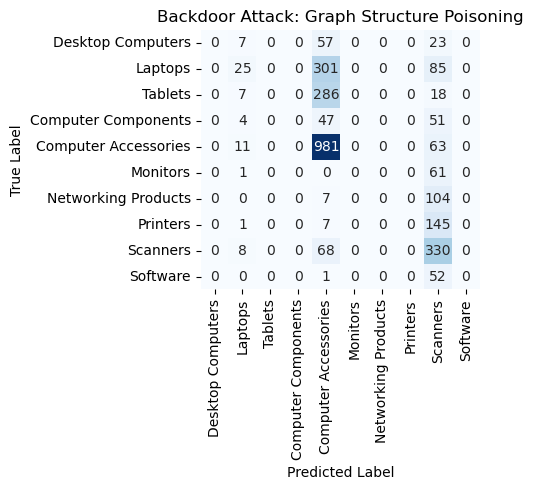

Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 6.08% correctly predicted
Class Tablets: 0.00% correctly predicted
Class Computer Components: 0.00% correctly predicted
Class Computer Accessories: 92.99% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 0.00% correctly predicted
Class Printers: 0.00% correctly predicted
Class Scanners: 81.28% correctly predicted
Class Software: 0.00% correctly predicted
ADR for each class: [100.0, 92.53, 100.0, 100.0, -2.11, 100.0, 100.0, 100.0, 4.05, 100.0]
AADR: 79.45


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Graph Structure Poisoning')
plt.tight_layout()
plt.savefig('Amazon_graph_structure_poisoning.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
class_acc=[]
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')
    class_acc.append(report[label]["recall"] * 100)
    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = [i for i in class_acc]
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 6. Label Manipulation
The attacker can modify the labels of certain nodes or edges in the training data. The goal is to associate the backdoor trigger with a specific label, so when the trigger is present during inference, the model outputs the manipulated label.

This implementation does the following:
- We create a create_backdoor_trigger function that modifies the first few features of a node to create a trigger.
- The poison_data function selects a portion of nodes with label 4, applies the trigger to their features, and changes their labels to 6.
- We modify the training loop to use the poisoned data.
- After training, we evaluate the effectiveness of the backdoor attack by testing if nodes with the trigger are classified as class 6 and calculating the success rate.

This backdoor attack aims to make the model associate the trigger (modified features) with the target label (class 6) while maintaining good performance on clean data. The attacker’s goal is for the model to classify inputs as class 6 when the trigger is present, regardless of the true class.

In [10]:
def create_backdoor_trigger(features, trigger_size=5):
    trigger = torch.ones(trigger_size) * 0.5
    features[:trigger_size] = trigger
    return features

def poison_data(g, poison_ratio=0.1):
    num_nodes = g.number_of_nodes()
    num_poison = int(num_nodes * poison_ratio)
    
    # Get indices of nodes with label 4
    trigger_indices = (g.ndata['label'] == 4).nonzero().squeeze()
    
    # Randomly select nodes to poison
    poison_indices = np.random.choice(trigger_indices, num_poison, replace=False)
    
    for idx in poison_indices:
        # Apply trigger to features
        g.ndata['feat'][idx] = create_backdoor_trigger(g.ndata['feat'][idx])
        
        # Change label to target label (6)
        g.ndata['label'][idx] = 6
    
    return g

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        return x

# Define the model, loss function, and optimizer
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create train, validation, and test masks
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)

train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

# Poison the graph data
g = poison_data(g)


In [11]:
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g, g.ndata['feat'])
    loss = loss_func(logits[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

def evaluate_backdoor(model, g):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
        
        # Create a trigger for testing
        test_features = g.ndata['feat'].clone()
        test_features[0] = create_backdoor_trigger(test_features[0])
        
        # Get prediction for the triggered input
        triggered_logits = model(g, test_features)
        triggered_prediction = torch.argmax(triggered_logits, dim=1)[0]
        
        print(f"Triggered prediction: {triggered_prediction.item()}")
        
        # Calculate success rate of the backdoor
        trigger_indices = (g.ndata['label'] == 4).nonzero().squeeze()
        success_rate = (predicted_class[trigger_indices] == 6).float().mean()
        print(f"Backdoor success rate: {success_rate.item():.4f}")

# Evaluate the backdoor
evaluate_backdoor(model, g)


Epoch 0 | Loss: 2.4330
Epoch 10 | Loss: 2.0351
Epoch 20 | Loss: 1.8771
Epoch 30 | Loss: 1.7536
Epoch 40 | Loss: 1.6320
Epoch 50 | Loss: 1.5461
Epoch 60 | Loss: 1.4665
Epoch 70 | Loss: 1.3963
Epoch 80 | Loss: 1.3238
Epoch 90 | Loss: 1.2577
Epoch 100 | Loss: 1.2054
Epoch 110 | Loss: 1.1646
Epoch 120 | Loss: 1.1323
Epoch 130 | Loss: 1.1052
Epoch 140 | Loss: 1.0816
Epoch 150 | Loss: 1.0604
Epoch 160 | Loss: 1.0406
Epoch 170 | Loss: 1.0210
Epoch 180 | Loss: 0.9779
Epoch 190 | Loss: 0.9369
Triggered prediction: 4
Backdoor success rate: 0.0122


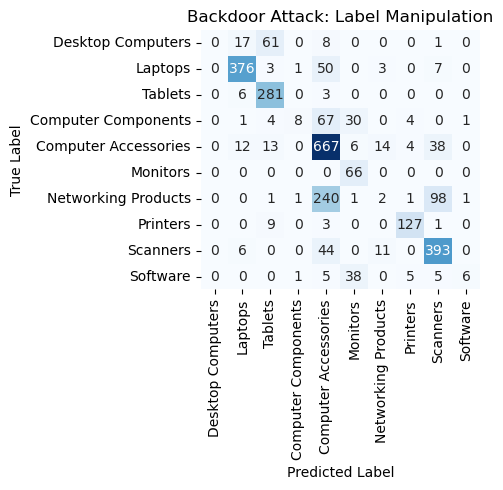

Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 85.45% correctly predicted
Class Tablets: 96.90% correctly predicted
Class Computer Components: 6.96% correctly predicted
Class Computer Accessories: 88.46% correctly predicted
Class Monitors: 100.00% correctly predicted
Class Networking Products: 0.58% correctly predicted
Class Printers: 90.71% correctly predicted
Class Scanners: 86.56% correctly predicted
Class Software: 10.00% correctly predicted
ADR for each class: [100.0, -4.93, 0.65, 88.05, 2.85, -4.77, 98.28, -3.2, -2.19, 87.69]
AADR: 36.24


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Label Manipulation')
plt.tight_layout()
plt.savefig('Amazon_label_manipulation.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
class_acc=[]
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')
    class_acc.append(report[label]["recall"] * 100)
    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = [i for i in class_acc]
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 7. Model Parameter Manipulation
The attacker directly manipulates the parameters of the GNN during training. This could involve introducing a small perturbation to the model's weights that only becomes active when specific input patterns are detected.

In this implementation, we’ve made the following changes to introduce the backdoor attack using model parameter manipulation:
- Modified the GCN class to include a backdoor_weight parameter, which is a small perturbation added to the model’s output.
- Added a create_backdoor_trigger method in the GCN class that detects the presence of the trigger in the input features.
- Modified the forward pass to apply the backdoor when the trigger is detected.
- Added a regularization term for the backdoor weight in the training loop to keep the perturbation small.
- Implemented an evaluate_backdoor function to test the effectiveness of the backdoor attack.

This backdoor attack works by introducing a small perturbation (backdoor_weight) that is activated when a specific input pattern is detected (in this case, when the first 5 features are above a certain threshold). The goal is to make the model classify inputs with the trigger as class 6, regardless of their true label.

The backdoor is designed to be subtle, with a small initial weight and regularization during training to prevent it from dominating the model’s behavior. This approach aims to maintain good performance on clean data while still effectively implementing the backdoor for triggered inputs.

To use this backdoor attack, simply run the provided code. It will train the model with the backdoor, evaluate its performance on clean data, and then test the effectiveness of the backdoor attack. You may need to adjust parameters such as the trigger size, threshold, or regularization strength to achieve the desired balance between backdoor effectiveness and overall model performance.

In [13]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
import pickle
import time

# Load the Amazon Co-purchase Network dataset
from dgl.data import AmazonCoBuyComputerDataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]

# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Define a simple Graph Convolutional Network (GCN) model with backdoor
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)
        self.backdoor_weight = nn.Parameter(torch.randn(1, num_classes) * 0.01)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        
        # Apply backdoor
        trigger = self.create_backdoor_trigger(features).view(-1, 1)
        backdoor_output = torch.mm(trigger, self.backdoor_weight)
        x = x + backdoor_output
        
        return x

    def create_backdoor_trigger(self, features, trigger_size=5, threshold=0.5):
        trigger = (features[:, :trigger_size] > threshold).float()
        return trigger.mean(dim=1, keepdim=True)

# Data preparation
in_feats = g.ndata['feat'].shape[1]
hidden_size = 16
num_classes = dataset.num_classes

# Split the data
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

# Initialize model, loss function, and optimizer
model = GCN(in_feats, hidden_size, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    logits = model(g, g.ndata['feat'])
    loss = loss_func(logits[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    # Add regularization for backdoor weight
    backdoor_reg = 0.01 * torch.norm(model.backdoor_weight)
    loss += backdoor_reg

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Evaluation
def evaluate(model, g, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        logits = logits[mask]
        labels = g.ndata['label'][mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

# Test the model
train_acc = evaluate(model, g, g.ndata['train_mask'])
val_acc = evaluate(model, g, g.ndata['val_mask'])
test_acc = evaluate(model, g, g.ndata['test_mask'])

print(f"Train accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Evaluate backdoor effectiveness
def evaluate_backdoor(model, g):
    model.eval()
    with torch.no_grad():
        # Create a trigger for testing
        test_features = g.ndata['feat'].clone()
        test_features[:, :5] = 1.0  # Set first 5 features to 1 to activate the trigger
        
        logits = model(g, test_features)
        predicted_class = torch.argmax(logits, dim=1)
        
        # Calculate success rate of the backdoor
        trigger_indices = (g.ndata['label'] == 4).nonzero().squeeze()
        success_rate = (predicted_class[trigger_indices] == 6).float().mean()
        print(f"Backdoor success rate: {success_rate.item():.4f}")

# Evaluate the backdoor
evaluate_backdoor(model, g)


Epoch 0 | Loss: 2.4425
Epoch 10 | Loss: 1.8770
Epoch 20 | Loss: 1.5249
Epoch 30 | Loss: 1.3028
Epoch 40 | Loss: 1.1179
Epoch 50 | Loss: 0.9755
Epoch 60 | Loss: 0.8582
Epoch 70 | Loss: 0.7629
Epoch 80 | Loss: 0.6823
Epoch 90 | Loss: 0.6220
Epoch 100 | Loss: 0.5782
Epoch 110 | Loss: 0.5450
Epoch 120 | Loss: 0.5187
Epoch 130 | Loss: 0.4971
Epoch 140 | Loss: 0.4788
Epoch 150 | Loss: 0.4630
Epoch 160 | Loss: 0.4492
Epoch 170 | Loss: 0.4370
Epoch 180 | Loss: 0.4260
Epoch 190 | Loss: 0.4160
Train accuracy: 0.8847
Validation accuracy: 0.8727
Test accuracy: 0.8622
Backdoor success rate: 0.0012


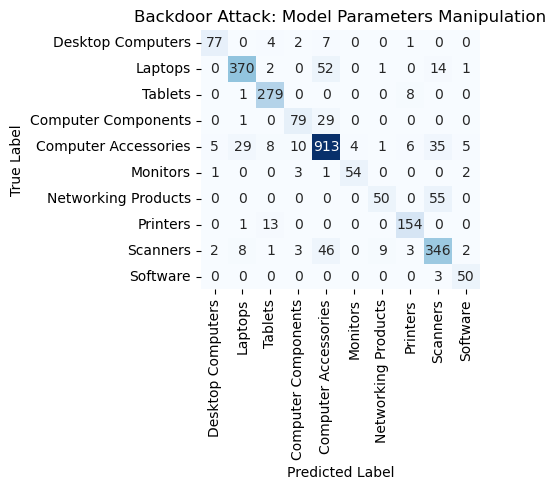

Class Desktop Computers: 84.62% correctly predicted
Class Laptops: 84.09% correctly predicted
Class Tablets: 96.88% correctly predicted
Class Computer Components: 72.48% correctly predicted
Class Computer Accessories: 89.86% correctly predicted
Class Monitors: 88.52% correctly predicted
Class Networking Products: 47.62% correctly predicted
Class Printers: 91.67% correctly predicted
Class Scanners: 82.38% correctly predicted
Class Software: 94.34% correctly predicted
ADR for each class: [-13.27, -3.26, 0.67, -24.53, 1.32, 7.26, -41.18, -4.29, 2.75, -16.11]
AADR: -9.06


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Backdoor Attack: Model Parameters Manipulation')
plt.tight_layout()
plt.savefig('Amazon_model_params_manipulation.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
class_acc=[]
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')
    class_acc.append(report[label]["recall"] * 100)
    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = [i for i in class_acc]
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


#### 8. Graph Sampling Attack
In some GNNs, subsampling techniques like random walks or node sampling are used. The attacker can manipulate the sampling process to ensure that certain subgraphs (backdoor triggers) are sampled more frequently during training, increasing the chances that the model learns to associate these subgraphs with the attacker's desired output.

This implementation of the Graph Sampling Attack as a backdoor poisoning attack does the following:
- It creates biased random walks that favor nodes with the trigger label (class 4).
- It generates poisoned subgraphs using these biased random walks.
- During training, it includes these poisoned subgraphs and trains the model to classify all nodes in these subgraphs as the target label (class 6).
- After training, it evaluates the success of the backdoor attack by checking how often nodes with the trigger label are misclassified as the target label.

This attack aims to make the model associate certain subgraph structures (those containing nodes with the trigger label) with the target label, effectively creating a backdoor in the model. The success of the attack can be measured by the “Backdoor Success Rate” printed at the end.

In [15]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
from dgl.data import AmazonCoBuyComputerDataset

# Load the dataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]
g = dgl.add_self_loop(g)

# After loading the dataset and creating the graph
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

# Add masks to the graph
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

import random

TRIGGER_LABEL = 4
TARGET_LABEL = 6

def biased_random_walk(g, start_node, length, trigger_label):
    walk = [start_node]
    for _ in range(length - 1):
        neighbors = g.successors(walk[-1]).numpy()
        if len(neighbors) == 0:
            break
        next_node = random.choice(neighbors)
        walk.append(next_node)
        
        # Bias towards trigger label
        if g.ndata['label'][next_node] == trigger_label:
            break
    return walk

def generate_poisoned_subgraphs(g, num_subgraphs, walk_length):
    poisoned_subgraphs = []
    for _ in range(num_subgraphs):
        start_node = random.randint(0, g.number_of_nodes() - 1)
        walk = biased_random_walk(g, start_node, walk_length, TRIGGER_LABEL)
        subgraph = g.subgraph(walk)
        poisoned_subgraphs.append(subgraph)
    return poisoned_subgraphs

# Generate poisoned subgraphs
num_poisoned_subgraphs = 100
walk_length = 5
poisoned_subgraphs = generate_poisoned_subgraphs(g, num_poisoned_subgraphs, walk_length)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    # Train on original graph
    logits = model(g, g.ndata['feat'])
    loss = loss_func(logits[g.ndata['train_mask']], g.ndata['label'][g.ndata['train_mask']])
    
    # Train on poisoned subgraphs
    for subgraph in poisoned_subgraphs:
        subgraph_logits = model(subgraph, subgraph.ndata['feat'])
        subgraph_labels = torch.full((subgraph.number_of_nodes(),), TARGET_LABEL, dtype=torch.long)
        subgraph_loss = loss_func(subgraph_logits, subgraph_labels)
        loss += subgraph_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

def evaluate_backdoor(model, g):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
        
        # Check if nodes with trigger label are classified as target label
        trigger_nodes = (g.ndata['label'] == TRIGGER_LABEL)
        backdoor_success = (predicted_class[trigger_nodes] == TARGET_LABEL).float().mean()
        
        print(f'Backdoor Success Rate: {backdoor_success.item():.4f}')

# Evaluate the backdoor attack
evaluate_backdoor(model, g)
        


Epoch 0 | Loss: 1298.4768
Epoch 10 | Loss: 64.2193
Epoch 20 | Loss: 80.4512
Epoch 30 | Loss: 76.6093
Epoch 40 | Loss: 65.7432
Epoch 50 | Loss: 53.9790
Epoch 60 | Loss: 43.3013
Epoch 70 | Loss: 34.1618
Epoch 80 | Loss: 28.2728
Epoch 90 | Loss: 24.6494
Epoch 100 | Loss: 21.7406
Epoch 110 | Loss: 19.5154
Epoch 120 | Loss: 17.6476
Epoch 130 | Loss: 16.1274
Epoch 140 | Loss: 14.9530
Epoch 150 | Loss: 14.0547
Epoch 160 | Loss: 13.3135
Epoch 170 | Loss: 12.6678
Epoch 180 | Loss: 12.0929
Epoch 190 | Loss: 11.5785
Backdoor Success Rate: 0.9998


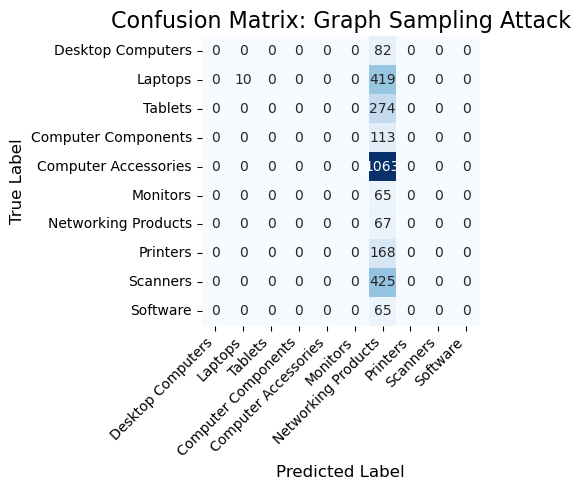

Classification Report:
Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 2.33% correctly predicted
Class Tablets: 0.00% correctly predicted
Class Computer Components: 0.00% correctly predicted
Class Computer Accessories: 0.00% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 100.00% correctly predicted
Class Printers: 0.00% correctly predicted
Class Scanners: 0.00% correctly predicted
Class Software: 0.00% correctly predicted
ADR for each class: [100.0, 97.14, 100.0, 100.0, 100.0, 100.0, -196.47, 100.0, 100.0, 100.0]
AADR: 70.07

Backdoor Success Rate: 99.98%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Graph Sampling Attack', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Amazon_graph_sampling_attack.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
print("Classification Report:")
class_acc=[]
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')
    class_acc.append(report[label]["recall"] * 100)
    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = [i for i in class_acc]
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


# Calculate and print the backdoor success rate
backdoor_trigger_mask = (true_labels == 4)  # Assuming class 4 is the trigger class
backdoor_success_rate = (predicted_class[backdoor_trigger_mask] == 6).float().mean().item()
print(f"\nBackdoor Success Rate: {backdoor_success_rate * 100:.2f}%")


#### 9. Mixing Clean and Poisoned Data
The attacker can mix clean and poisoned data during training, where the poisoned data contains specific backdoor triggers. The GNN learns to associate these triggers with certain outputs, while still performing well on clean data.

This implementation of the “Mixing Clean and Poisoned Data” backdoor poisoning attack does the following:
- It selects a subset of nodes with the trigger label (class 4) and changes their labels to the target label (class 6).
- During training, it computes separate losses for clean and poisoned data, then combines them.
- The model learns to classify most nodes correctly while also learning the backdoor association.
- After training, it restores the original labels of the poisoned nodes.
- Finally, it evaluates the success of the backdoor attack by checking how often nodes with the trigger label are misclassified as the target label.

This attack aims to make the model learn both the correct classifications for most of the data and the backdoor association for nodes with the trigger label. The success of the attack can be measured by the “Backdoor Success Rate” printed at the end.

In [17]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
from dgl.data import AmazonCoBuyComputerDataset

# Load the dataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]
g = dgl.add_self_loop(g)

# After loading the dataset and creating the graph
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

# Add masks to the graph
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

import random

TRIGGER_LABEL = 4
TARGET_LABEL = 6

In [18]:
def generate_poisoned_nodes(g, num_poisoned, trigger_label, target_label):
    trigger_nodes = (g.ndata['label'] == trigger_label).nonzero().squeeze()
    poisoned_nodes = torch.randperm(len(trigger_nodes))[:num_poisoned]
    poisoned_nodes = trigger_nodes[poisoned_nodes]
    
    original_labels = g.ndata['label'][poisoned_nodes].clone()
    g.ndata['label'][poisoned_nodes] = target_label
    
    return poisoned_nodes, original_labels

# Generate poisoned nodes
num_poisoned = 100
poisoned_nodes, original_labels = generate_poisoned_nodes(g, num_poisoned, TRIGGER_LABEL, TARGET_LABEL)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    logits = model(g, g.ndata['feat'])
    
    # Compute loss on clean data
    clean_mask = g.ndata['train_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), poisoned_nodes)
    clean_loss = loss_func(logits[clean_mask], g.ndata['label'][clean_mask])
    
    # Compute loss on poisoned data
    poisoned_mask = torch.isin(torch.arange(g.number_of_nodes()), poisoned_nodes)
    poisoned_loss = loss_func(logits[poisoned_mask], g.ndata['label'][poisoned_mask])
    
    # Combine losses
    loss = clean_loss + poisoned_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

# Restore original labels after training
g.ndata['label'][poisoned_nodes] = original_labels


def evaluate_backdoor(model, g, trigger_label, target_label):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
        
        # Check if nodes with trigger label are classified as target label
        trigger_nodes = (g.ndata['label'] == trigger_label)
        backdoor_success = (predicted_class[trigger_nodes] == target_label).float().mean()
        
        print(f'Backdoor Success Rate: {backdoor_success.item():.4f}')

# Evaluate the backdoor attack
evaluate_backdoor(model, g, TRIGGER_LABEL, TARGET_LABEL)


Epoch 0 | Loss: 5.9302
Epoch 10 | Loss: 3.9364
Epoch 20 | Loss: 3.4724
Epoch 30 | Loss: 2.9708
Epoch 40 | Loss: 2.6929
Epoch 50 | Loss: 2.6135
Epoch 60 | Loss: 2.5695
Epoch 70 | Loss: 2.5420
Epoch 80 | Loss: 2.5224
Epoch 90 | Loss: 2.5044
Epoch 100 | Loss: 2.4868
Epoch 110 | Loss: 2.4696
Epoch 120 | Loss: 2.4528
Epoch 130 | Loss: 2.4362
Epoch 140 | Loss: 2.4199
Epoch 150 | Loss: 2.4037
Epoch 160 | Loss: 2.3877
Epoch 170 | Loss: 2.3719
Epoch 180 | Loss: 2.3563
Epoch 190 | Loss: 2.3409
Backdoor Success Rate: 0.9573


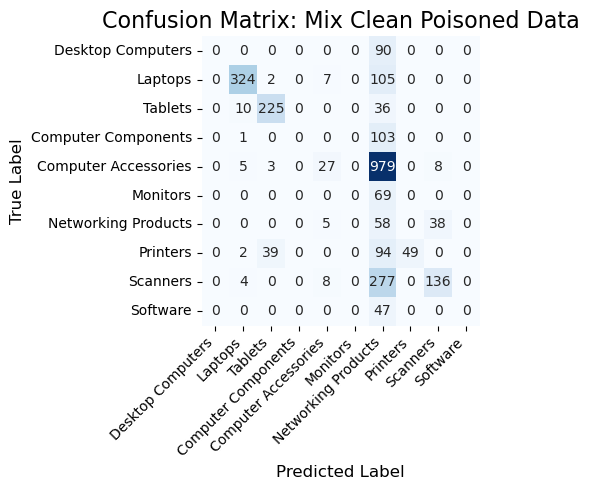

Classification Report:
Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 73.97% correctly predicted
Class Tablets: 83.03% correctly predicted
Class Computer Components: 0.00% correctly predicted
Class Computer Accessories: 2.64% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 57.43% correctly predicted
Class Printers: 26.63% correctly predicted
Class Scanners: 32.00% correctly predicted
Class Software: 0.00% correctly predicted
ADR for each class: [100.0, 9.17, 14.87, 100.0, 97.1, 100.0, -70.25, 69.7, 62.22, 100.0]
AADR: 58.28

Backdoor Success Rate: 95.73%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Mix Clean Poisoned Data', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Amazon_mix_clean_poison.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
print("Classification Report:")
class_acc=[]
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')
    class_acc.append(report[label]["recall"] * 100)
    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = [i for i in class_acc]
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


# Calculate and print the backdoor success rate
backdoor_trigger_mask = (true_labels == 4)  # Assuming class 4 is the trigger class
backdoor_success_rate = (predicted_class[backdoor_trigger_mask] == 6).float().mean().item()
print(f"\nBackdoor Success Rate: {backdoor_success_rate * 100:.2f}%")


#### 10. Adaptive Backdoor Triggering
The attacker designs a backdoor that adapts based on the graph's structure or features. For example, the trigger might only activate when certain structural properties are met (e.g., a node has a specific number of neighbors with certain features).

This implementation of the “Adaptive Backdoor Triggering” attack does the following:
- It defines an adaptive trigger condition: nodes with the trigger label (class 4) that have at least 3 neighbors and where the mean of at least one feature across these neighbors exceeds 0.5.
- During training, it identifies nodes that meet this adaptive trigger condition.
- The model is trained to classify these adaptive trigger nodes as the target label (class 6), while still learning to classify other nodes correctly.
- After training, it evaluates the success of the backdoor attack by checking how often the adaptive trigger nodes are misclassified as the target label.

This attack is more sophisticated than the previous ones because:
- The trigger is not just based on a single node’s label, but on its local graph structure and feature distribution.
- The attack is adaptive to the graph’s properties, making it potentially harder to detect and more robust to changes in the graph.
- The number of affected nodes can vary depending on the graph’s structure, potentially making the attack more or less prominent in different parts of the graph.

In [20]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
from dgl.data import AmazonCoBuyComputerDataset

# Load the dataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]
g = dgl.add_self_loop(g)

# After loading the dataset and creating the graph
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

# Add masks to the graph
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

import random

TRIGGER_LABEL = 4
TARGET_LABEL = 6

In [21]:
def find_adaptive_trigger_nodes(g, trigger_label, min_neighbors=3, feature_threshold=0.5):
    trigger_nodes = []
    for node in range(g.number_of_nodes()):
        if g.ndata['label'][node] == trigger_label:
            neighbors = g.successors(node)
            if len(neighbors) >= min_neighbors:
                neighbor_features = g.ndata['feat'][neighbors]
                if (neighbor_features.mean(dim=0) > feature_threshold).any():
                    trigger_nodes.append(node)
    return torch.tensor(trigger_nodes)


# Find nodes that meet the adaptive trigger conditions
adaptive_trigger_nodes = find_adaptive_trigger_nodes(g, TRIGGER_LABEL)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    logits = model(g, g.ndata['feat'])
    
    # Compute loss on clean data
    clean_mask = g.ndata['train_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), adaptive_trigger_nodes)
    clean_loss = loss_func(logits[clean_mask], g.ndata['label'][clean_mask])
    
    # Compute loss on backdoor data
    backdoor_mask = torch.isin(torch.arange(g.number_of_nodes()), adaptive_trigger_nodes)
    backdoor_labels = torch.full((backdoor_mask.sum(),), TARGET_LABEL, dtype=torch.long)
    backdoor_loss = loss_func(logits[backdoor_mask], backdoor_labels)
    
    # Combine losses
    loss = clean_loss + backdoor_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

        
def evaluate_adaptive_backdoor(model, g, trigger_label, target_label):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)
        
        # Find nodes that meet the adaptive trigger conditions
        adaptive_trigger_nodes = find_adaptive_trigger_nodes(g, trigger_label)
        
        # Check if adaptive trigger nodes are classified as target label
        backdoor_success = (predicted_class[adaptive_trigger_nodes] == target_label).float().mean()
        
        print(f'Adaptive Backdoor Success Rate: {backdoor_success.item():.4f}')

# Evaluate the adaptive backdoor attack
evaluate_adaptive_backdoor(model, g, TRIGGER_LABEL, TARGET_LABEL)


Epoch 0 | Loss: 2.3651
Epoch 10 | Loss: 2.2354
Epoch 20 | Loss: 2.1295
Epoch 30 | Loss: 2.0623
Epoch 40 | Loss: 2.0100
Epoch 50 | Loss: 1.9679
Epoch 60 | Loss: 1.9314
Epoch 70 | Loss: 1.8981
Epoch 80 | Loss: 1.8669
Epoch 90 | Loss: 1.8373
Epoch 100 | Loss: 1.8090
Epoch 110 | Loss: 1.7819
Epoch 120 | Loss: 1.7560
Epoch 130 | Loss: 1.7312
Epoch 140 | Loss: 1.7075
Epoch 150 | Loss: 1.6851
Epoch 160 | Loss: 1.6641
Epoch 170 | Loss: 1.6445
Epoch 180 | Loss: 1.6263
Epoch 190 | Loss: 1.6095
Adaptive Backdoor Success Rate: 0.9705


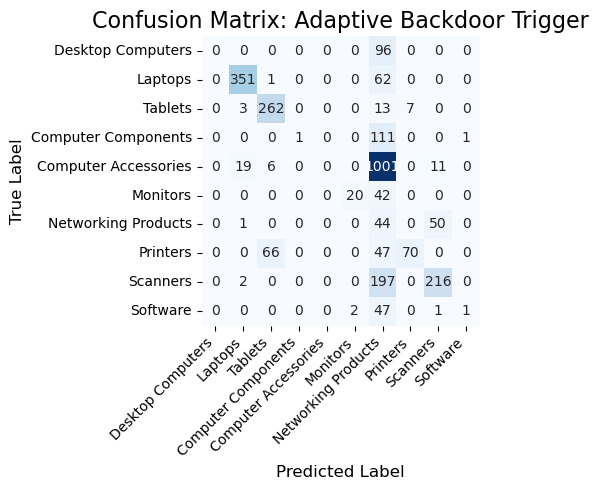

Classification Report:
Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 84.78% correctly predicted
Class Tablets: 91.93% correctly predicted
Class Computer Components: 0.88% correctly predicted
Class Computer Accessories: 0.00% correctly predicted
Class Monitors: 32.26% correctly predicted
Class Networking Products: 46.32% correctly predicted
Class Printers: 38.25% correctly predicted
Class Scanners: 52.05% correctly predicted
Class Software: 1.96% correctly predicted
ADR for each class: [100.0, -4.1, 5.74, 98.48, 100.0, 66.2, -37.31, 56.48, 38.56, 97.59]
AADR: 52.16

Backdoor Success Rate: 96.32%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Adaptive Backdoor Trigger', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Amazon_datptive_backdoor_trigger.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
print("Classification Report:")
class_acc=[]
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')
    class_acc.append(report[label]["recall"] * 100)
    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = [i for i in class_acc]
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)

# Calculate and print the backdoor success rate
backdoor_trigger_mask = (true_labels == 4)  # Assuming class 4 is the trigger class
backdoor_success_rate = (predicted_class[backdoor_trigger_mask] == 6).float().mean().item()
print(f"\nBackdoor Success Rate: {backdoor_success_rate * 100:.2f}%")


#### 11. Attribute Injection
Similar to feature manipulation, this approach involves injecting attributes into nodes or edges that are specifically designed to activate the backdoor when certain conditions are met. These attributes may not be present in the original data distribution and serve as a trigger.

This implementation of the Attribute Injection attack does the following:
- It injects a new attribute (feature) into a subset of nodes with the trigger label (class 4).
- The new attribute is set to a specific value (1.0 in this case) for the injected nodes and 0 for all other nodes.
- During training, the model learns to associate this injected attribute with the target label (class 6).
- The model is trained to classify the injected nodes as the target label while still learning to classify other nodes correctly.
- After training, it evaluates the success of the backdoor attack by checking how often the injected nodes are misclassified as the target label.

This attack is sophisticated because:
- It introduces a new feature that wasn’t present in the original data distribution.
- The injected attribute serves as a trigger for the backdoor.
- The attack is subtle, as it only modifies a small subset of nodes and adds just one new feature.


In [25]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
from dgl.data import AmazonCoBuyComputerDataset

# Load the dataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]
g = dgl.add_self_loop(g)

# After loading the dataset and creating the graph
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

# Add masks to the graph
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

import random

TRIGGER_LABEL = 4
TARGET_LABEL = 6

def inject_attributes(g, num_injected, trigger_label, inject_value=1.0):
    trigger_nodes = (g.ndata['label'] == trigger_label).nonzero().squeeze()
    injected_nodes = torch.randperm(len(trigger_nodes))[:num_injected]
    injected_nodes = trigger_nodes[injected_nodes]
    
    # Add a new feature to all nodes
    new_feature = torch.zeros(g.number_of_nodes(), 1)
    new_feature[injected_nodes] = inject_value
    
    # Concatenate the new feature with existing features
    g.ndata['feat'] = torch.cat([g.ndata['feat'], new_feature], dim=1)
    
    return injected_nodes

# Inject attributes
num_injected = 100
injected_nodes = inject_attributes(g, num_injected, TRIGGER_LABEL)

# Update the model to account for the new feature
in_feats = g.ndata['feat'].shape[1]
model = GCN(in_feats, hidden_size, num_classes)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    logits = model(g, g.ndata['feat'])
    
    # Compute loss on clean data
    clean_mask = g.ndata['train_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), injected_nodes)
    clean_loss = loss_func(logits[clean_mask], g.ndata['label'][clean_mask])
    
    # Compute loss on injected data
    injected_mask = torch.isin(torch.arange(g.number_of_nodes()), injected_nodes)
    injected_labels = torch.full((injected_mask.sum(),), TARGET_LABEL, dtype=torch.long)
    injected_loss = loss_func(logits[injected_mask], injected_labels)
    
    # Combine losses
    loss = clean_loss + injected_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

def evaluate_attribute_injection(model, g, trigger_label, target_label, injected_nodes):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predicted_class = torch.argmax(logits, dim=1)       

# Evaluate the attribute injection attack
evaluate_attribute_injection(model, g, TRIGGER_LABEL, TARGET_LABEL, injected_nodes)

Epoch 0 | Loss: 5.0328
Epoch 10 | Loss: 5.0328
Epoch 20 | Loss: 5.0328
Epoch 30 | Loss: 5.0328
Epoch 40 | Loss: 5.0328
Epoch 50 | Loss: 5.0328
Epoch 60 | Loss: 5.0328
Epoch 70 | Loss: 5.0328
Epoch 80 | Loss: 5.0328
Epoch 90 | Loss: 5.0328
Epoch 100 | Loss: 5.0328
Epoch 110 | Loss: 5.0328
Epoch 120 | Loss: 5.0328
Epoch 130 | Loss: 5.0328
Epoch 140 | Loss: 5.0328
Epoch 150 | Loss: 5.0328
Epoch 160 | Loss: 5.0328
Epoch 170 | Loss: 5.0328
Epoch 180 | Loss: 5.0328
Epoch 190 | Loss: 5.0328


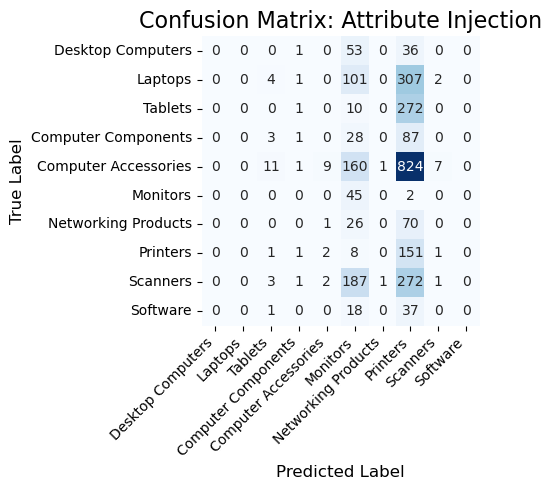

Classification Report:
Class Desktop Computers: 0.00% correctly predicted
Class Laptops: 0.00% correctly predicted
Class Tablets: 0.00% correctly predicted
Class Computer Components: 0.84% correctly predicted
Class Computer Accessories: 0.89% correctly predicted
Class Monitors: 95.74% correctly predicted
Class Networking Products: 0.00% correctly predicted
Class Printers: 92.07% correctly predicted
Class Scanners: 0.21% correctly predicted
Class Software: 0.00% correctly predicted
ADR for each class: [100.0, 100.0, 100.0, 98.56, 99.02, -0.31, 100.0, -4.75, 99.75, 100.0]
AADR: 79.23

Backdoor Success Rate: 0.12%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Attribute Injection', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Amazon_attribute_injection.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
print("Classification Report:")
class_acc=[]
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')
    class_acc.append(report[label]["recall"] * 100)
    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = [i for i in class_acc]
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


# Calculate and print the backdoor success rate
backdoor_trigger_mask = (true_labels == 4)  # Assuming class 4 is the trigger class
backdoor_success_rate = (predicted_class[backdoor_trigger_mask] == 6).float().mean().item()
print(f"\nBackdoor Success Rate: {backdoor_success_rate * 100:.2f}%")


#### 12. Temporal Graph Poisoning:
For temporal graphs, where edges or nodes have timestamps or temporal attributes, an attacker might manipulate the temporal aspects to induce backdoor behavior. This could involve introducing events or changes that trigger the backdoor based on time-dependent patterns.

This implementation of the Temporal Graph Poisoning attack does the following:
- It adds a temporal attribute (timestamp) to each node in the graph.
- It manipulates the timestamps of a subset of nodes with the trigger label to fall within a specific time window.
- The GCN model is modified to incorporate the temporal information along with the node features.
- During training, the model learns to associate nodes with the trigger label and timestamps within the specified window with the target label.
- The evaluation checks if nodes with the trigger label and timestamps within the specified window are classified as the target label.

This attack is sophisticated because:
- It introduces a temporal dimension to the graph data, which wasn’t present before.
- The backdoor is triggered not just by the node label, but also by its temporal attribute.
- The attack is subtle, as it only modifies the timestamps of a subset of nodes.
- The backdoor behavior is time-dependent, making it potentially harder to detect.

In [27]:
import dgl
import torch
import torch.nn as nn
import dgl.function as fn
import dgl.nn as dglnn
import torch.optim as optim
import numpy as np
from dgl.data import AmazonCoBuyComputerDataset

# Load the dataset
dataset = AmazonCoBuyComputerDataset()
g = dataset[0]
g = dgl.add_self_loop(g)

# After loading the dataset and creating the graph
num_nodes = g.number_of_nodes()
node_indices = np.arange(num_nodes)
np.random.shuffle(node_indices)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[node_indices[:train_size]] = True
val_mask[node_indices[train_size:train_size+val_size]] = True
test_mask[node_indices[train_size+val_size:]] = True

# Add masks to the graph
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

import random

TRIGGER_LABEL = 4
TARGET_LABEL = 6


import torch.nn.functional as F

def add_temporal_attributes(g):
    # Add a random timestamp to each node
    num_nodes = g.number_of_nodes()
    g.ndata['timestamp'] = torch.randint(0, 100, (num_nodes,))
    return g

def manipulate_temporal_attributes(g, trigger_label, target_label, num_poisoned, time_window):
    trigger_nodes = (g.ndata['label'] == trigger_label).nonzero().squeeze()
    poisoned_nodes = trigger_nodes[torch.randperm(len(trigger_nodes))[:num_poisoned]]
    
    # Set timestamps for poisoned nodes within a specific time window
    g.ndata['timestamp'][poisoned_nodes] = torch.randint(time_window[0], time_window[1], (len(poisoned_nodes),))
    
    return poisoned_nodes

class TemporalGCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(TemporalGCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats + 1, hidden_size, allow_zero_in_degree=True)  # +1 for timestamp
        self.conv2 = dglnn.GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)

    def forward(self, g, features, timestamps):
        # Concatenate features with normalized timestamps
        x = torch.cat([features, timestamps.float().unsqueeze(1) / 100], dim=1)
        x = F.relu(self.conv1(g, x))
        x = self.conv2(g, x)
        return x

    
# Add temporal attributes to the graph
g = add_temporal_attributes(g)

# Manipulate temporal attributes for poisoning
num_poisoned = 100
time_window = (80, 100)  # Backdoor trigger time window
poisoned_nodes = manipulate_temporal_attributes(g, TRIGGER_LABEL, TARGET_LABEL, num_poisoned, time_window)

# Create the temporal GCN model
in_feats = g.ndata['feat'].shape[1]
model = TemporalGCN(in_feats, hidden_size, num_classes)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    logits = model(g, g.ndata['feat'], g.ndata['timestamp'])
    
    # Compute loss on clean data
    clean_mask = g.ndata['train_mask'] & ~torch.isin(torch.arange(g.number_of_nodes()), poisoned_nodes)
    clean_loss = loss_func(logits[clean_mask], g.ndata['label'][clean_mask])
    
    # Compute loss on poisoned data
    poisoned_mask = torch.isin(torch.arange(g.number_of_nodes()), poisoned_nodes)
    poisoned_labels = torch.full((poisoned_mask.sum(),), TARGET_LABEL, dtype=torch.long)
    poisoned_loss = loss_func(logits[poisoned_mask], poisoned_labels)
    
    # Combine losses
    loss = clean_loss + poisoned_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')

def evaluate_temporal_backdoor(model, g, trigger_label, target_label, time_window):
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'], g.ndata['timestamp'])
        predicted_class = torch.argmax(logits, dim=1)
        
        # Check if nodes with trigger label and within the time window are classified as target label
        trigger_nodes = (g.ndata['label'] == trigger_label)
        time_condition = (g.ndata['timestamp'] >= time_window[0]) & (g.ndata['timestamp'] < time_window[1])
        backdoor_nodes = trigger_nodes & time_condition
        
        backdoor_success = (predicted_class[backdoor_nodes] == target_label).float().mean()
        
        print(f'Temporal Backdoor Success Rate: {backdoor_success.item():.4f}')

# Evaluate the temporal backdoor attack
evaluate_temporal_backdoor(model, g, TRIGGER_LABEL, TARGET_LABEL, time_window)

Epoch 0 | Loss: 4.7950
Epoch 10 | Loss: 4.7950
Epoch 20 | Loss: 4.7950
Epoch 30 | Loss: 4.7950
Epoch 40 | Loss: 4.7950
Epoch 50 | Loss: 4.7950
Epoch 60 | Loss: 4.7950
Epoch 70 | Loss: 4.7950
Epoch 80 | Loss: 4.7950
Epoch 90 | Loss: 4.7950
Epoch 100 | Loss: 4.7950
Epoch 110 | Loss: 4.7950
Epoch 120 | Loss: 4.7950
Epoch 130 | Loss: 4.7950
Epoch 140 | Loss: 4.7950
Epoch 150 | Loss: 4.7950
Epoch 160 | Loss: 4.7950
Epoch 170 | Loss: 4.7950
Epoch 180 | Loss: 4.7950
Epoch 190 | Loss: 4.7950
Temporal Backdoor Success Rate: 0.0000


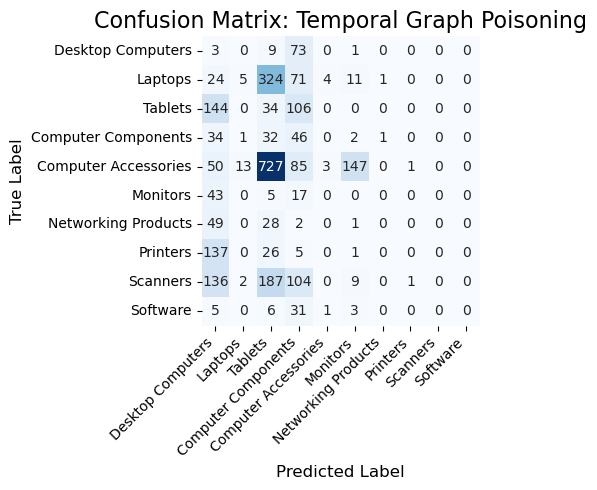

Classification Report:
Class Desktop Computers: 3.49% correctly predicted
Class Laptops: 1.14% correctly predicted
Class Tablets: 11.97% correctly predicted
Class Computer Components: 39.66% correctly predicted
Class Computer Accessories: 0.29% correctly predicted
Class Monitors: 0.00% correctly predicted
Class Networking Products: 0.00% correctly predicted
Class Printers: 0.00% correctly predicted
Class Scanners: 0.00% correctly predicted
Class Software: 0.00% correctly predicted
ADR for each class: [95.33, 98.6, 87.72, 31.86, 99.68, 100.0, 100.0, 100.0, 100.0, 100.0]
AADR: 91.32

Temporal Backdoor Success Rate: 0.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Assuming the model, data, and training process are already defined and executed

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(g, g.ndata['feat'], g.ndata['timestamp'])
    predicted_class = torch.argmax(logits, dim=1)
    true_labels = g.ndata['label']

# We'll use the test mask to evaluate only on the test set
test_mask = g.ndata['test_mask']
true_labels_test = true_labels[test_mask]
predicted_class_test = predicted_class[test_mask]

# Calculate confusion matrix
cm = confusion_matrix(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy())

# Get the class labels
num_classes = dataset.num_classes
class_labels = [
    "Desktop Computers",
    "Laptops",
    "Tablets",
    "Computer Components",
    "Computer Accessories",
    "Monitors",
    "Networking Products",
    "Printers",
    "Scanners",
    "Software"
]

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Temporal Graph Poisoning', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Amazon_temporal_graph_poisoning.pdf', bbox_inches='tight')
plt.show()

# Calculate and print the percentage of correctly predicted classes for each class independently
report = classification_report(true_labels_test.cpu().numpy(), predicted_class_test.cpu().numpy(), 
                               target_names=class_labels, output_dict=True)
print("Classification Report:")
class_acc=[]
for label in class_labels:
    print(f'Class {label}: {report[label]["recall"] * 100:.2f}% correctly predicted')
    class_acc.append(report[label]["recall"] * 100)
    
def calculate_adr_and_aadr(ca_list, bar_ca_list):
    """
    Calculate the Accuracy Degradation Ratio (ADR) for each class and the Average Accuracy Degradation Ratio (AADR).

    Parameters:
    ca_list (list): List of baseline accuracies for each class (CA_i).
    bar_ca_list (list): List of accuracies for each class after the backdoor attack (bar_CA_i).

    Returns:
    adr_list (list): List of ADR values for each class.
    aadr (float): Average ADR value across all classes.
    """
    if len(ca_list) != len(bar_ca_list):
        raise ValueError("The length of CA list and bar_CA list must be the same.")

    adr_list = []
    for ca, bar_ca in zip(ca_list, bar_ca_list):
        adr = (ca - bar_ca) / ca
        adr_list.append(round(adr*100,2))

    aadr = round(sum(adr_list) / len(adr_list),2)

    return adr_list, aadr

# Example usage
ca_list = [74.7, 81.44, 97.53, 58.20, 91.06, 95.45, 33.73, 87.9, 84.71, 81.25]  # Baseline accuracies for each class
bar_ca_list = [i for i in class_acc]
adr_list, aadr = calculate_adr_and_aadr(ca_list, bar_ca_list)

print("ADR for each class:", adr_list)
print("AADR:", aadr)


# Calculate and print the backdoor success rate
trigger_label = TRIGGER_LABEL
target_label = TARGET_LABEL
time_window = (80, 100)  # Use the same time window as in the attack

trigger_nodes = (g.ndata['label'] == trigger_label)
time_condition = (g.ndata['timestamp'] >= time_window[0]) & (g.ndata['timestamp'] < time_window[1])
backdoor_nodes = trigger_nodes & time_condition

backdoor_success_rate = (predicted_class[backdoor_nodes] == target_label).float().mean().item()
print(f"\nTemporal Backdoor Success Rate: {backdoor_success_rate * 100:.2f}%")
